In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller, acf, pacf
from scipy.optimize import curve_fit
import  statsmodels.api as sm
import itertools
import warnings 
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Electricity Generation by Source_D_20211110_093557.csv", skiprows = [0], header = 1,parse_dates = ["YearValue"], index_col = 'YearValue')

In [3]:
df

,EnergySource,EnergySourceType,Generation_GWh,PLF_Percent
YearValue,,,,
2017-01-01,COAL,NON-RENEWABLE,1082449.240,74.1
2017-01-01,HYDRO,NON-RENEWABLE,122521.203,0.0
2017-01-01,BIOMASS-BAGASSE,RENEWABLE,14158.640,0.0
2017-01-01,SMALL HYDRO,RENEWABLE,7672.661,0.0
2017-01-01,SOLAR,RENEWABLE,13564.023,0.0
...,...,...,...,...
2012-01-01,LIGNITE,NON-RENEWABLE,24394.180,71.0
2017-01-01,NAPHTHA,NON-RENEWABLE,26.380,0.0
2018-01-01,NAPHTHA,NON-RENEWABLE,52.960,0.0


In [4]:
dfc = df.groupby(['YearValue', "EnergySourceType"])['Generation_GWh'].sum()

In [5]:
dfc

YearValue   EnergySourceType
2006-01-01  NON-RENEWABLE        690197.420
            RENEWABLE              6863.410
2007-01-01  NON-RENEWABLE        741454.060
            RENEWABLE             10075.990
2008-01-01  NON-RENEWABLE        789735.640
            RENEWABLE             19528.047
2009-01-01  NON-RENEWABLE        815478.740
            RENEWABLE             23204.257
2010-01-01  NON-RENEWABLE        870322.700
            RENEWABLE             28204.789
2011-01-01  NON-RENEWABLE        926113.360
            RENEWABLE             33244.892
2012-01-01  NON-RENEWABLE       1005239.010
            RENEWABLE             40926.470
2013-01-01  NON-RENEWABLE       1051806.190
            RENEWABLE             47090.132
2014-01-01  NON-RENEWABLE       1110506.220
            RENEWABLE             52883.865
2015-01-01  NON-RENEWABLE       1204473.290
            RENEWABLE             59473.176
2016-01-01  NON-RENEWABLE       1269310.070
            RENEWABLE             67826.931
201

In [6]:
year = []
listr = []
listnr = []
for i in range(dfc.shape[0]):
    a, b = dfc.index[i]
    if(i & 1):
        listr.append(dfc[i])
    else:
        year.append(a.year)
        listnr.append(dfc[i])

In [7]:
df.sort_values('YearValue', inplace = True)

In [8]:
df['EnergySource'].unique()

array(['COAL', 'WIND', 'NUCLEAR', 'HYDRO', 'LIGNITE', 'NATURAL GAS',
       'DIESEL', 'RENEWABLES', 'BIOMASS-BAGASSE', 'WASTE', 'SOLAR',
       'SMALL HYDRO', 'NAPHTHA'], dtype=object)

In [9]:
ratio = np.array(listnr)/np.array(listr)
dfcoal  = df[df['EnergySource']  == "COAL"]
dfcoal['ratio'] = list(ratio)
dfcoal =dfcoal[['ratio']]

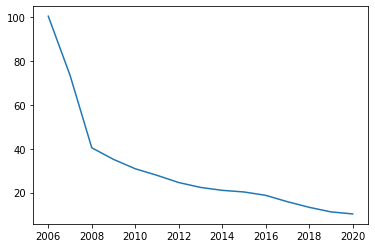

In [10]:

plt.figure()
plt.plot( year, ratio)

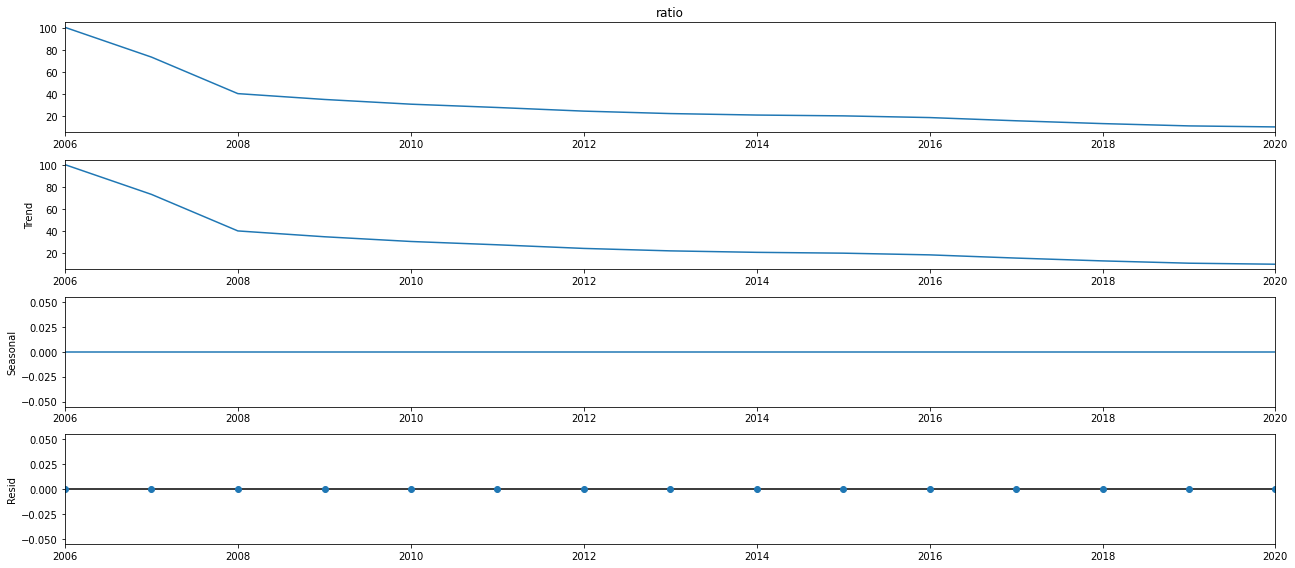

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = (18, 8)
decomposition = sm.tsa.seasonal_decompose(dfcoal['ratio'], model='additive')
fig = decomposition.plot()
plt.show()

In [14]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 2) for x in list(itertools.product(p, d, q))]
# print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [15]:
param1 = ()
param2 = ()
mxaic = 1000000000
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dfcoal['ratio'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if(mxaic > results.aic):
                mxaic = results.aic
                param1 = param
                param2 = param_seasonal
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [16]:
#ARIMA(1, 1, 1)x(1, 0, 1, 2)12 - AIC:27.277687091576425
print(param1, param2)

(1, 1, 1) (1, 0, 1, 2)


In [17]:
mod = sm.tsa.statespace.SARIMAX(dfcoal['ratio'],
                                order=param1,
                                seasonal_order=param2,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8853      0.043     20.516      0.000       0.801       0.970
ma.L1          3.5525      4.524      0.785      0.432      -5.314      12.419
ar.S.L2        0.0441      0.027      1.649      0.099      -0.008       0.097
ma.S.L2       -1.0001   3563.323     -0.000      1.000   -6984.985    6982.984
sigma2         0.0190     67.632      0.000      1.000    -132.537     132.575


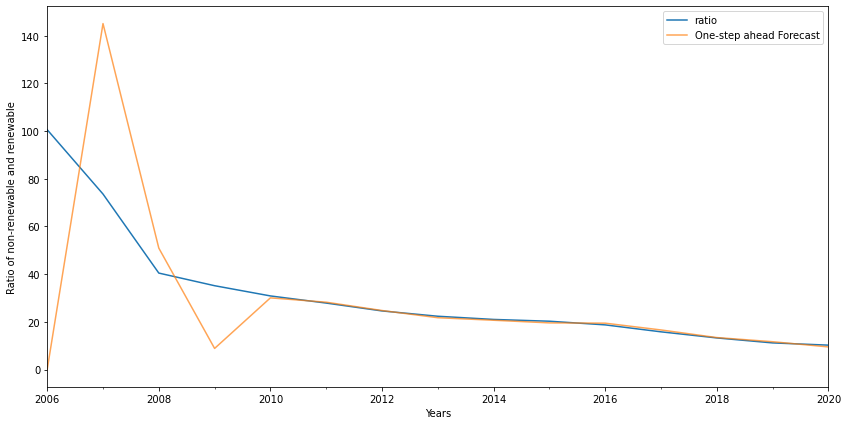

In [18]:
pred = results.get_prediction(start=pd.to_datetime('2006-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = dfcoal['2006':].plot()
pred.predicted_mean.plot(ax = ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Years')
ax.set_ylabel('Ratio of non-renewable and renewable')
plt.legend()
plt.show()


In [19]:
y_forecasted = np.array(pred.predicted_mean)
y_truth = np.array(dfcoal['2006':])
print(y_forecasted.shape,y_truth.shape)
mse = ((y_forecasted[2:] - y_truth[2:]) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

(15,) (15, 1)
The Mean Squared Error of our forecasts is 194.65


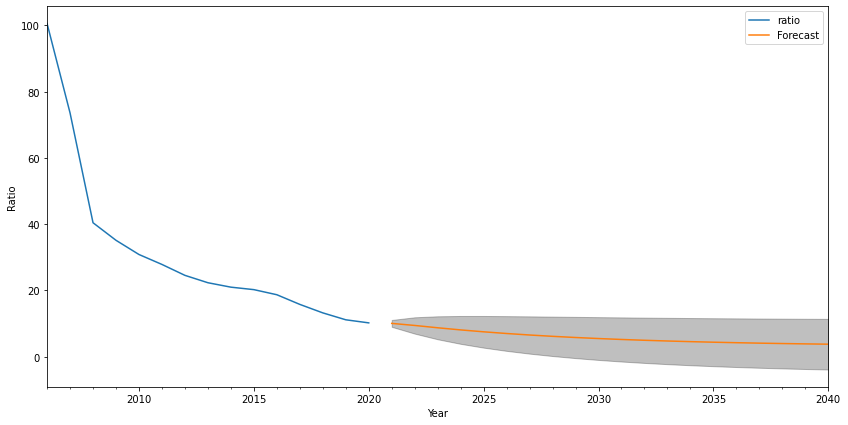

In [20]:
pred_uc = results.get_forecast(steps=20)
pred_ci = pred_uc.conf_int()
ax = dfcoal.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Ratio')
plt.legend()
plt.show()

In [21]:
df_pred = pd.DataFrame(pred_uc.predicted_mean)

In [22]:
df_pred

,predicted_mean
2021-01-01,10.062632
2022-01-01,9.440415
2023-01-01,8.738980
2024-01-01,8.096660
2025-01-01,7.521348
2026-01-01,7.011061
2027-01-01,6.558989
2028-01-01,6.158709
2029-01-01,5.804312
2030-01-01,5.490548


In [23]:
final = pd.concat([dfcoal, df_pred])

In [24]:
final

,ratio,predicted_mean
2006-01-01,100.561881,NaN
2007-01-01,73.586224,NaN
2008-01-01,40.441097,NaN
2009-01-01,35.143497,NaN
2010-01-01,30.857267,NaN
2011-01-01,27.857313,NaN
2012-01-01,24.562075,NaN
2013-01-01,22.336021,NaN
2014-01-01,20.998961,NaN
2015-01-01,20.252379,NaN


In [25]:
final.to_csv("ratio_renew_nonrenew_forcast.csv")
